# Physics-informed neural networks (+ Flax)

2024년 여름 대학생을 위한 인공지능 튜토리얼 - 과학기계학습 맛보기

2024년 7월 17일 실습

In [ ]:
from collections.abc import Callable, Sequence
from functools import partial

import flax.linen as nn
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import matplotlib_inline.backend_inline
import numpy as np
import optax
import scipy as sp
from tqdm.auto import tqdm

matplotlib_inline.backend_inline.set_matplotlib_formats("png2x")
plt.rcParams.update({"figure.constrained_layout.use": True})

참고: NumPy나 JAX의 행렬은 기본값으로 행 우선 순서(row-major order)로 저장되고 1D 어레이는 보통 행 벡터처럼 동작합니다.

행 우선 순서인 언어에서는, 배치(batch) 차원 등을 생각하면 $\mathbb{R}^n \to \mathbb{R}^m$ 선형 변환을 $N$개의 $n$차원 벡터 $r_1, r_2, \dotsc, r_N$에 대해 동시에 할 때

$$
W_{(m \times n)} \begin{pmatrix}
    \vert & \vert & & \vert \\
    r_1^\mathsf{T} & r_2^\mathsf{T} & \cdots & r_N^\mathsf{T} \\
    \vert & \vert & & \vert
\end{pmatrix}_{(n \times N)}
$$

로 계산하는 것보다

$$
\begin{pmatrix}
    \text{—} \;\; r_1 \;\; \text{—} \\
    \text{—} \;\; r_2 \;\; \text{—} \\
    \vdots \\
    \text{—} \;\; r_N \;\; \text{—}
\end{pmatrix}_{(N \times n)} W_{(n \times m)}
$$

로 계산하는 것이 구현이 편하고 성능이 좋습니다.

## 다층 퍼셉트론 직접 구현하기

다층 퍼셉트론(multilayer perceptron, MLP)은 퍼셉트론(linear, dense, fully-connected로도 부름) 레이어를 여러 층을 쌓은 인공 신경망입니다.
위에서 말한 행 우선 순서에 적합하도록, 입력 $x$와 출력 $y$ 등을 행 벡터로 보고, 다음과 같이 구현합니다.

$$
\begin{aligned}
    h^{(1)} &= \sigma(b^{(0)} + xW^{(0)}) \\
    h^{(2)} &= \sigma(b^{(1)} + h^{(1)}W^{(1)}) \\
    &\vdots \\
    h^{(L - 1)} &= \sigma(b^{(L - 2)} + h^{(L - 2)}W^{(L - 2)}) \\
    y &= b^{(L - 1)} + h^{(L - 1)}W^{(L - 1)}
\end{aligned}
$$

PyTorch나 TensorFlow의 경우 보통 모델과 파라미터가 합쳐진 형태로 구현을 하고, 모델에 포함된 파라미터를 계속 수정하는 식으로 모델을 훈련합니다.
JAX는 그렇게 하지 않고, 모델(계산 부분)과 파라미터를 분리해서 관리합니다.

MLP의 구조(입력층의 크기, 은닉층의 수와 각각의 크기, 출력층의 크기)를 지정하면 그 모델이 사용할 정확한 크기의 파라미터를 초기화해 주는 함수와, 입력($x$)과 파라미터($b^{(i)}$, $W^{(i)}$)를 받아, 출력($y$)을 계산하는 함수를 작성합니다. 파라미터는 다음과 같은 딕셔너리(`dict`) 형식을 사용하겠습니다.

```python
{
    "params": {
        "Dense_0": {
            "bias": ...,  # b^{(0)}
            "kernel": ...,  # W^{(0)}
        },
        "Dense_1": {
            "bias": ...,  # b^{(1)}
            "kernel": ...,  # W^{(1)}
        },
        # ...
    },
}
```

In [ ]:
class ManualMLP:
    def __init__(self, features, activation=jnp.tanh):
        self.features = features  # 각 은닉층과 출력의 크기(입력 크기 제외)
        self.activation = activation  # 활성화 함수

    def init(self, key, x):
        # 보통 난수를 사용해야 하는 함수는 첫 번째 인자로 키를 받음
        # 입력 차원은 더미 x(모양만 필요)를 받아서 확정
        layer_keys = jax.random.split(key, len(self.features))

        features = (x.shape[-1],) + tuple(self.features)
        params = {"params": {}} # params라는 dictionary에 다 저장해넣음
        for i, (layer_key, in_features, out_features) in enumerate(
            zip(layer_keys, features, features[1:])
        ):
            params["params"][f"Dense_{i}"] = {
                "bias": jnp.zeros(out_features),
                "kernel": (
                    jnp.sqrt(1 / in_features)
                    * jax.random.normal(
                        layer_key, shape=(in_features, out_features)
                    )
                ),  # LeCun normal initialization
            }
        return params

    def apply(self, params, x):
        # 파라미터를 객체(인스턴스)에 저장해 두는 것이 아니라
        # 함수를 부를 때 x와 함께 같이 넘겨 주어 계산.
        # 사용자가 오용해서 `self.features`와 `self.activation`을
        # 억지로 바꾸지 않는 한 JIT 컴파일에 포함되어도 문제는 없음
        for i in range(len(self.features)):
            dense_params = params["params"][f"Dense_{i}"]
            x = dense_params["bias"] + x @ dense_params["kernel"]
            if i < len(self.features) - 1:
                x = self.activation(x)
        return x

In [ ]:
model = ManualMLP((5, 1))
# => 입력 크기 ? -> 은닉층 크기 5 -> 출력 크기 1

key = jax.random.key(78)
params = model.init(key, jnp.zeros((2,)))
# 크기가 (2,)인 입력 -> 입력 크기 2로 확정하여 파라미터를 만듦
# 크기만 중요하고 값은 아무 상관 없음

params

{'params': {'Dense_0': {'bias': Array([0., 0., 0., 0., 0.], dtype=float32),
   'kernel': Array([[-1.3550441 ,  0.66525805, -0.35675827, -0.90526015, -0.2415924 ],
          [ 0.40787628, -0.00753416, -0.07203963,  0.35522676, -0.60577434]],      dtype=float32)},
  'Dense_1': {'bias': Array([0.], dtype=float32),
   'kernel': Array([[ 0.0194957 ],
          [-0.19525081],
          [ 0.1380145 ],
          [-0.1751945 ],
          [ 0.09800039]], dtype=float32)}}}

In [ ]:
jax.tree.map(lambda x: x.shape, params)

{'params': {'Dense_0': {'bias': (5,), 'kernel': (2, 5)},
  'Dense_1': {'bias': (1,), 'kernel': (5, 1)}}}

In [ ]:
x = jnp.array([1.5, 2.5])

y_pred = model.apply(params, x)  # 실제 모델 계산
y_pred

Array([-0.26341045], dtype=float32)

## 1D boundary layer problem: 시험해(trial solution)로 경계 조건 강제(hard constraints)

정의역:

$$
x \in [0, 1]
$$

미분 방정식:

$$
-\epsilon u_{xx} - u_x = 1 \\
\quad u(0) = u(1) = 0.
$$

모델: MLP의 함숫값에 $x(1 - x)$를 곱한 모양의 시험해를 $u$의 근사로 모델하여, 경계 조건을 강제합니다.

$$
u^\theta(x) = x (1 - x) \operatorname{MLP}^\theta(x)
$$

손실 함수:

$$
L(\theta) = \frac1N \sum_{i = 1}^N (-\epsilon u_{xx}^\theta(x_i) - u_x^\theta(x_i) - 1)^2
$$

<details>
<summary>참고: 해</summary>

$$
u(x) = -x + \frac{1 - e^{-x / \epsilon}}{1 - e^{-1 / \epsilon}}
$$

</details>

In [ ]:
# 문제와 모델 설정
domain = (0.0, 1.0)
eps = 1e-4

mlp = ManualMLP((20, 20, 20, 1))

# 함수 모양(params 제외하고) () -> ()
# 즉, 입력 스칼라 -> 출력 스칼라
def boundary_layer_u(params, x): #여기가 u_theta 정의하는곳
    return x * (1 - x) * mlp.apply(params, jnp.array([x])).reshape()
#PyTorch 에서는 mlp(params,x) 뭐 이런식으로 바로 넣으면 되는데, jax에서는 apply를 항상 써줘야해요
# () -> () 는 x를 scalar로 받아옴
def boundary_layer_pde(params, x): # x를 하나 받아오는것이기 때문에 forward를 받아와도 상관없어요
    u_x = jax.jacfwd(boundary_layer_u, argnums=1)
    u_xx = jax.jacfwd(u_x, argnums=1)
# 2번 미분 하는거면 forward 한 번 쓰고, backward 한 번 써보는게 좋아요.
    return -eps * u_xx(params, x) - u_x(params, x) - 1
# (N,) -> (N,) 는 x를 vector로 받아옴
# `params`는 병렬처리하지 않고(None) `x`만 첫 번째 배치 차원(0)을 병렬 처리
batched_boundary_layer_pde = jax.vmap(boundary_layer_pde, in_axes=(None, 0))
# (None, 0)은 첫번째는 parameters에 해당하는 것이고, parameter는 건들지 말고
# x만 하나하나 계산 하라는뜻
# (N,) -> ()
def boundary_layer_loss(params, x):
    return (batched_boundary_layer_pde(params, x) ** 2).mean()

참고: 보통 PINN의 최적화 방식으로 L-BFGS가 많이 쓰이는데, 이번 실습에 사용하는 Optax 라이브러리에 [L-BFGS](https://optax.readthedocs.io/en/latest/api/optimizers.html#optax.lbfgs)가 [지난주에 추가](https://github.com/google-deepmind/optax/releases/tag/v0.2.3)되었고, 아직 Colab에 업데이트되지 않았습니다.
(JAXopt에는 L-BFGS가 들어있으나, JAXopt는 개발이 중지되었고, Optax로 기능 통합 중입니다.)
이번 실습에서는 대신 Adam을 사용합니다.

In [ ]:
# 훈련 설정
key = jax.random.key(78)
n_epochs = 80_000
n_x_samples = 300
learning_rate = optax.cosine_decay_schedule(3e-4, decay_steps=n_epochs)
optimizer = optax.adam(learning_rate) # optimizer를 adam으로 설정

params = mlp.init(key, jnp.zeros((1,)))
optimizer_state = optimizer.init(params)
# 최근에 나온 좋은 optimizer는 momentum도 보는것이 있어서, 우리가 3가지를 들고 다닐거에요
# 파라미터 업데이트를 할 때
#     params = jax.tree.map(
#         lambda param, grad: param - learning_rate * grad, params, grads
#     )
# 처럼 직접 하는 대신, Optax의 optimizer를 이용
@jax.jit
def step(params, optimizer_state, x):
    loss, grads = jax.value_and_grad(boundary_layer_loss)(params, x)
    updates, optimizer_state = optimizer.update(grads, optimizer_state)
    # parameter를 optimizer에게 주고 새로운 parameter, 새로운 optimizer state를 받아온다.
    params = optax.apply_updates(params, updates)
    return params, optimizer_state, loss

이번에는 등간격 격자를 만들어서 데이터 포인트로 사용하겠습니다.

그 외에 매 반복마다 균등 난수(uniform random)를 새로 뽑아서 사용하는 방법이나, 소볼(Sobol) 수열이나 할톤(Halton) 수열 같은 저불일치 수열(low-discrepancy sequence, 혹은 준난수 quasi-random)를 사용하는 방법도 있습니다.

In [ ]:
x_samples = jnp.linspace(*domain, n_x_samples)

loss_history = []
for i in tqdm(range(1, n_epochs + 1)):
    params, optimizer_state, loss_value = step(
        params, optimizer_state, x_samples
    )

    loss_history.append(loss_value.item())
    if i % (n_epochs // 20) == 0:
        tqdm.write(f"Epoch {i}: {loss_value = :g}")

  0%|          | 0/80000 [00:00<?, ?it/s]

Epoch 4000: loss_value = 0.999865
Epoch 8000: loss_value = 0.999775
Epoch 12000: loss_value = 0.999049
Epoch 16000: loss_value = 0.990553
Epoch 20000: loss_value = 0.50144
Epoch 24000: loss_value = 0.251849
Epoch 28000: loss_value = 0.0751521
Epoch 32000: loss_value = 0.00408118
Epoch 36000: loss_value = 0.000143326
Epoch 40000: loss_value = 4.11423e-05
Epoch 44000: loss_value = 4.23596e-05
Epoch 48000: loss_value = 2.30538e-05
Epoch 52000: loss_value = 2.17266e-05
Epoch 56000: loss_value = 1.6698e-05
Epoch 60000: loss_value = 1.64849e-05
Epoch 64000: loss_value = 1.30411e-05
Epoch 68000: loss_value = 1.17154e-05
Epoch 72000: loss_value = 1.06479e-05
Epoch 76000: loss_value = 9.88173e-06
Epoch 80000: loss_value = 9.64865e-06


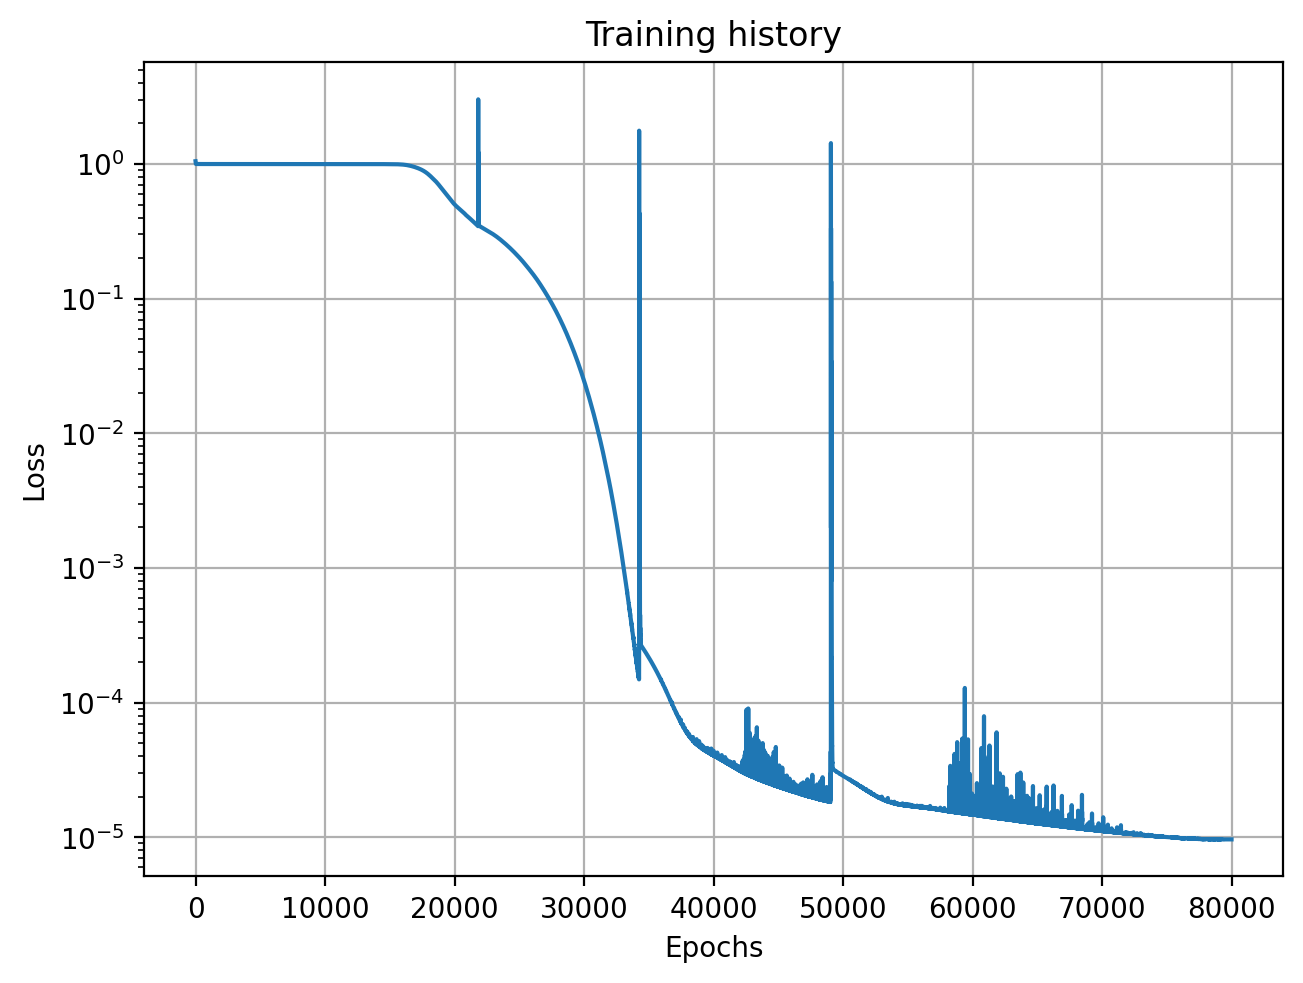

In [ ]:
fig, ax = plt.subplots()
ax.semilogy(loss_history)
ax.set(xlabel="Epochs", ylabel="Loss", title="Training history")
ax.grid()
pass

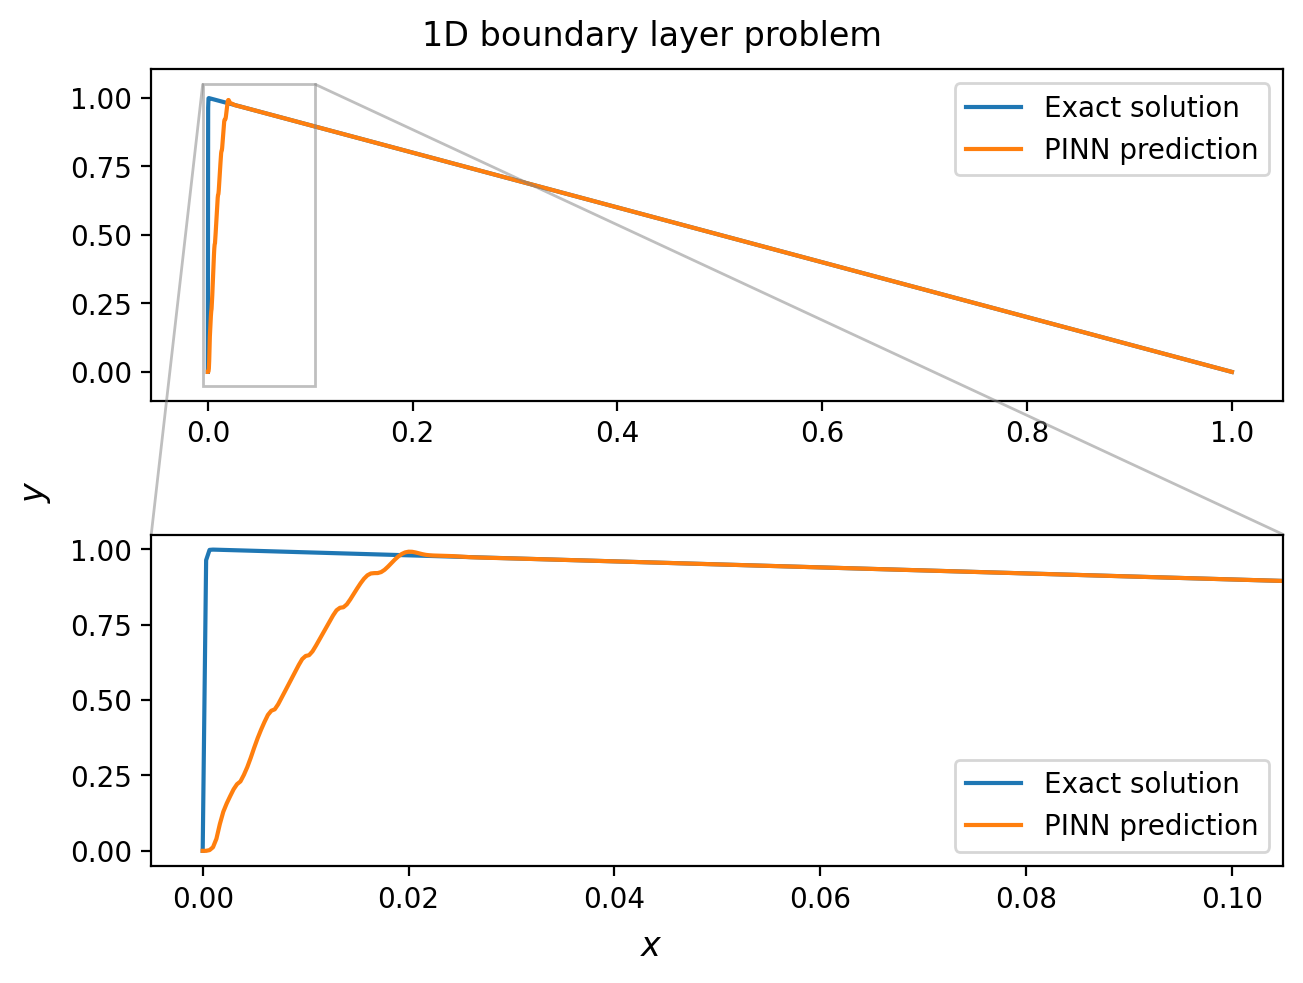

In [ ]:
def boundary_layer_exact(x, eps):
    u = -x + (1 - jnp.exp(-x / eps)) / (1 - jnp.exp(-1 / eps))
    return u

# x_samples에 없던 값도 (내삽이 아니라 바로) 예측 가능
x_test = jnp.linspace(*domain, 10 * n_x_samples)
u_pred = jax.vmap(boundary_layer_u, in_axes=(None, 0))(params, x_test)
u_true = boundary_layer_exact(x_test, eps)

fig, (ax, ax_zoom) = plt.subplots(2, 1)

ax.plot(x_test, u_true, label="Exact solution")
ax.plot(x_test, u_pred, label="PINN prediction")
ax.legend()

ax_zoom.plot(x_test, u_true, label="Exact solution")
ax_zoom.plot(x_test, u_pred, label="PINN prediction")
ax_zoom.set_xlim((-0.005, 0.105))
ax_zoom.legend()

ax.indicate_inset_zoom(ax_zoom)
fig.supxlabel(R"$x$")
fig.supylabel(R"$y$")
fig.suptitle("1D boundary layer problem")
pass

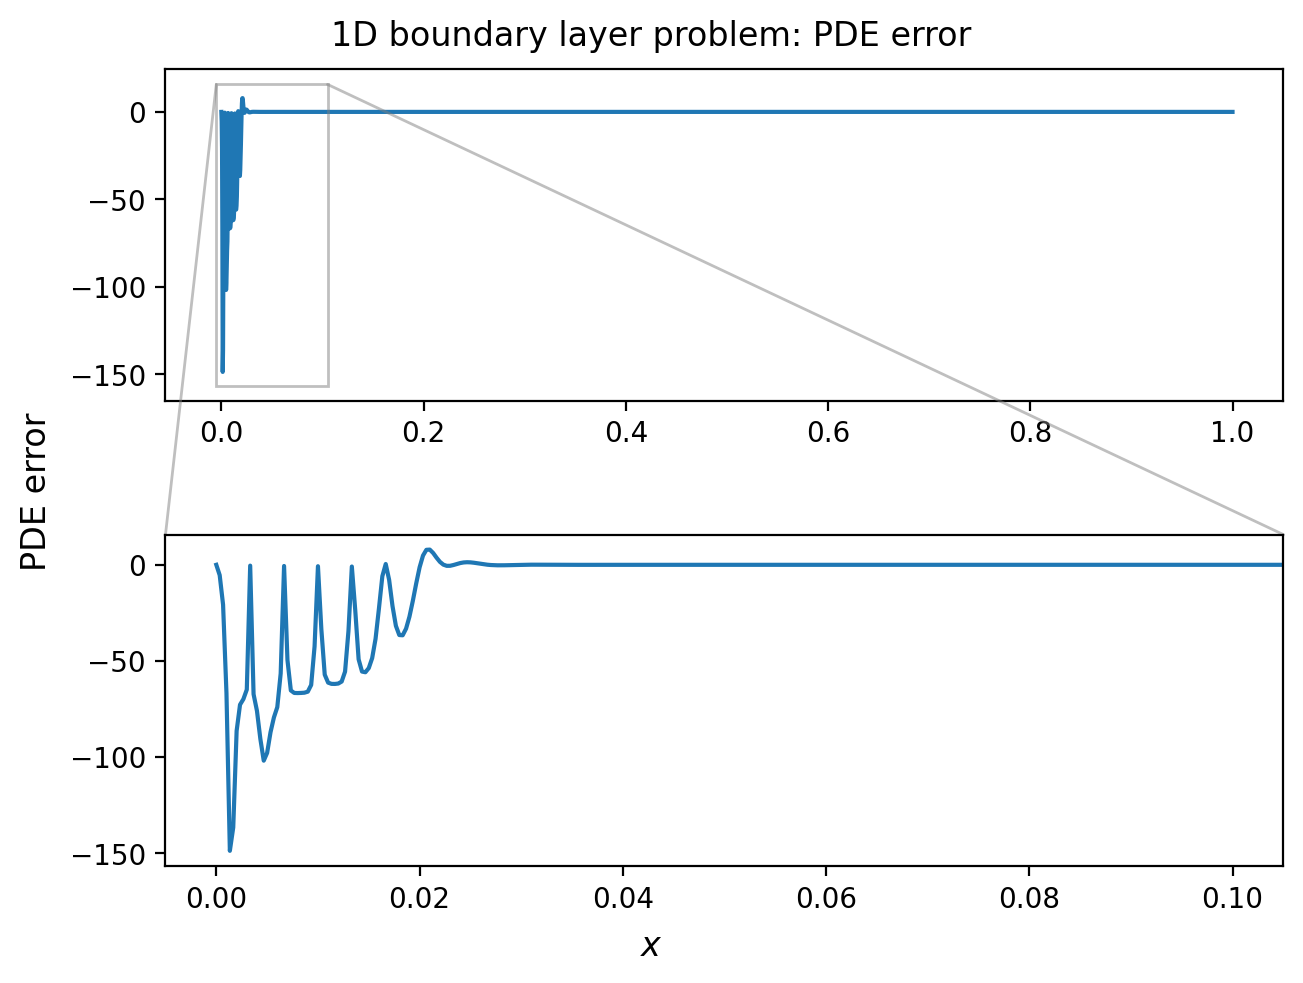

In [ ]:
pde_test = batched_boundary_layer_pde(params, x_test)

fig, (ax, ax_zoom) = plt.subplots(2, 1)

ax.plot(x_test, pde_test)
ax_zoom.plot(x_test, pde_test)
ax_zoom.set_xlim((-0.005, 0.105))

ax.indicate_inset_zoom(ax_zoom)
fig.supxlabel(R"$x$")
fig.supylabel("PDE error")
fig.suptitle("1D boundary layer problem: PDE error")
pass

## Flax로 MLP 구현하기

위의 `ManualMLP`의 형태는 Flax의 모듈 구조 중 가장 기본적인 인터페이스가 동일하도록 따라한 것입니다.

[Flax를 이용](https://flax.readthedocs.io/en/latest/guides/flax_fundamentals/flax_basics.html#module-basics)하면 다음과 같이 작성할 수 있습니다.
이렇게 계산 부분만 작성하면 계산 과정에 등장하는 다른 모듈을 분석하여 파라미터를 초기화하는 `.init()`과 주어진 파라미터로 모델을 실행하는 `.apply()` 함수를 자동으로 만들어 줍니다.

In [ ]:
class MLP(nn.Module):
    features: Sequence[int]
    activation: Callable = jnp.tanh

    @nn.compact
    def __call__(self, x):
        for i, out_features in enumerate(self.features):
            x = nn.Dense(
                out_features, kernel_init=nn.initializers.lecun_normal()
            )(x) # dense에다가 out features 넣어주고, initial과 output 갯수를 넘겨줌
            if i < len(self.features) - 1:
                x = self.activation(x)
                # initial과 parameter를 넣지 않았는데, 자동으로 parameter와 initial을 넣어줌
        return x

In [ ]:
model = MLP((5, 1))

key = jax.random.key(78)
params = model.init(key, jnp.zeros((2,)))

params

{'params': {'Dense_0': {'kernel': Array([[-0.03616341,  0.13113007,  0.53836703, -0.72711635,  0.22002998],
          [ 0.6621107 , -0.6484048 , -0.18050463, -1.3429725 ,  0.51266557]],      dtype=float32),
   'bias': Array([0., 0., 0., 0., 0.], dtype=float32)},
  'Dense_1': {'kernel': Array([[-0.503063  ],
          [-0.35913688],
          [ 0.0128446 ],
          [ 0.04773453],
          [ 0.30857202]], dtype=float32),
   'bias': Array([0.], dtype=float32)}}}

In [ ]:
jax.tree.map(lambda x: x.shape, params)

{'params': {'Dense_0': {'bias': (5,), 'kernel': (2, 5)},
  'Dense_1': {'bias': (1,), 'kernel': (5, 1)}}}

In [ ]:
x = jnp.array([1.5, 2.5])

y_pred = model.apply(params, x)
y_pred

Array([0.09768431], dtype=float32)

## Burger’s equation: 경계 조건도 손실 함수를 통해 훈련

정의역:

$$
t \in [0, 1], \quad x \in [-1, 1]
$$

미분 방정식:

$$
u_t + uu_x - (0.01 / \pi)u_{xx} = 0 \\
u(0, x) = -\sin(\pi x) \\
u(t, -1) = u(t, 1) = 0
$$

모델: BC를 시험해의 모양으로 강제하는 대신 손실 함수에 포함시킵니다.

$$
u^\theta(t, x) = \operatorname{MLP}^\theta((t, x))
$$

손실 함수:

$$
L(\theta) = \frac{1}{N_\mathrm{phy}} \sum_{i = 1}^{N_\mathrm{phy}} (u_t^\theta(t_i, x_i) + u^\theta(t_i, x_i)u_x^\theta(t_i, x_i) - (0.01 / \pi) u_xx^\theta(t_i, x_i))^2
+ \frac{1}{N_\mathrm{bdy}} \sum_{j = 1}^{N_\mathrm{bdy}} (u^\theta(t_j, x_j) - u(t_j, x_j))^2
$$

In [ ]:
# 문제와 모델 설정
domain_t = (0.0, 1.0)
domain_x = (-1.0, 1.0)

# ManualMLP로 바꿔도 똑같이 동작함
mlp = MLP((20, 20, 20, 20, 20, 20, 20, 20, 1))

def burger_boundary(t, x):
    # HACK: t = 0이거나, x = -1, 1 값만 들어온다고 가정
    return -jnp.sin(jnp.pi * x)

# (), () -> ()
def burger_u(params, t, x):
    return mlp.apply(params, jnp.array([t, x])).reshape()

# (N,), (N,) -> (N,)
batched_burger_u = jax.vmap(burger_u, in_axes=(None, 0, 0))

# (), () -> ()
def burger_pde(params, t, x):
    u_t = jax.jacfwd(burger_u, argnums=1) # t에 대한 미분
    u_x = jax.jacfwd(burger_u, argnums=2) # x에 대한 미분
    u_xx = jax.jacfwd(u_x, argnums=2) # u_x를 x에 대한 미분 한번 더

    return (
        u_t(params, t, x)
        + burger_u(params, t, x) * u_x(params, t, x)
        - 0.01 / jnp.pi * u_xx(params, t, x)
    )

# (N,), (N,) -> (N,)
batched_burger_pde = jax.vmap(burger_pde, in_axes=(None, 0, 0))

# (N_interior, 2), (N_boundary, 2) -> ()
def burger_loss(params, tx_interior, tx_boundary):
    physics_loss = (
        batched_burger_pde(params, tx_interior[:, 0], tx_interior[:, 1]) ** 2
    ).mean()
    boundary_loss = (
        (
            burger_boundary(tx_boundary[:, 0], tx_boundary[:, 1])
            - batched_burger_u(params, tx_boundary[:, 0], tx_boundary[:, 1])
        )
        ** 2
    ).mean()

    total_loss = physics_loss + boundary_loss

    return total_loss, (physics_loss, boundary_loss)

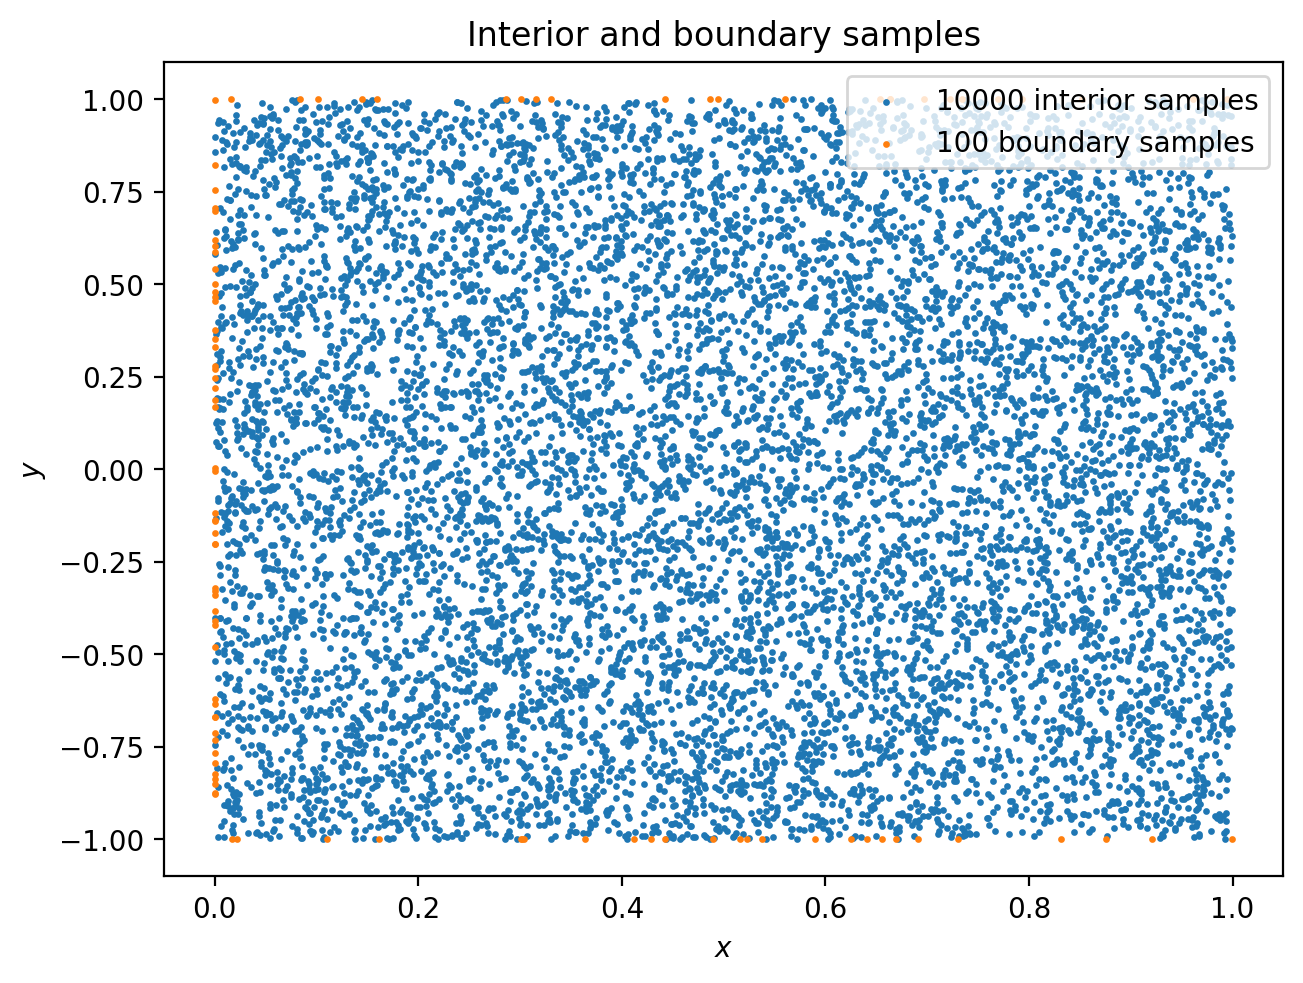

In [ ]:
# 샘플링
@partial(jax.jit, static_argnums=(1,))
def sample_burger_interior(key, n_samples):
    t_key, x_key = jax.random.split(key)

    return jnp.column_stack([
        jax.random.uniform(
            t_key, shape=(n_samples,), minval=domain_t[0], maxval=domain_t[1]
        ),
        jax.random.uniform(
            x_key, shape=(n_samples,), minval=domain_x[0], maxval=domain_x[1]
        ),
    ])

@partial(jax.jit, static_argnums=(1,))
def sample_burger_boundary(key, n_samples):
    n_initial_samples = n_samples // 2
    n_boundary_samples = n_samples - n_initial_samples

    initial_key, boundary_t_key, boundary_x_key = jax.random.split(key, 3)

    x_initial = jax.random.uniform(
        initial_key,
        shape=(n_initial_samples,),
        minval=domain_x[0],
        maxval=domain_x[1],
    )
    initial_samples = jnp.column_stack([
        jnp.full_like(x_initial, domain_t[0]),
        x_initial,
    ])

    boundary_samples = jnp.column_stack([
        jax.random.uniform(
            boundary_t_key,
            shape=(n_boundary_samples,),
            minval=domain_t[0],
            maxval=domain_t[1],
        ),
        jax.random.choice(
            boundary_x_key, jnp.array(domain_x), shape=(n_boundary_samples,)
        ),
    ])

    return jnp.concatenate([initial_samples, boundary_samples])

interior_key, boundary_key = jax.random.split(jax.random.key(78))
tx_interior = sample_burger_interior(interior_key, n_samples=10000)
tx_boundary = sample_burger_boundary(interior_key, n_samples=100)

fig, ax = plt.subplots()
ax.scatter(
    tx_interior[:, 0],
    tx_interior[:, 1],
    s=2,
    label=f"{tx_interior.shape[0]} interior samples",
)
ax.scatter(
    tx_boundary[:, 0],
    tx_boundary[:, 1],
    s=2,
    label=f"{tx_boundary.shape[0]} boundary samples",
)
ax.legend()
ax.set(xlabel=R"$x$", ylabel=R"$y$", title="Interior and boundary samples")
pass

In [ ]:
# 훈련 설정
model_key, data_key = jax.random.split(jax.random.key(78))
n_epochs = 20_000
learning_rate = optax.cosine_decay_schedule(1e-3, decay_steps=n_epochs)
n_interior_samples = 10_000
n_boundary_samples = 100
optimizer = optax.adam(learning_rate)

params = mlp.init(model_key, jnp.zeros((2,)))
optimizer_state = optimizer.init(params)

@jax.jit
def step(params, optimizer_state, tx_interior, tx_boundary):
    loss, grads = jax.value_and_grad(burger_loss, has_aux=True)(
        params, tx_interior, tx_boundary
    )
    updates, optimizer_state = optimizer.update(grads, optimizer_state)
    params = optax.apply_updates(params, updates)
    return params, optimizer_state, loss

In [ ]:
loss_history = []
physics_loss_history = []
boundary_loss_history = []
for i in tqdm(range(1, n_epochs + 1)):
    # 매번 새로운 무작위 점을 샘플링
    data_key, interior_key, boundary_key = jax.random.split(data_key, 3)
    tx_interior = sample_burger_interior(interior_key, n_interior_samples)
    tx_boundary = sample_burger_boundary(boundary_key, n_boundary_samples)

    params, optimizer_state, (loss_value, (physics_loss, boundary_loss)) = step(
        params, optimizer_state, tx_interior, tx_boundary
    )
    loss_history.append(loss_value.item())
    physics_loss_history.append(physics_loss.item())
    boundary_loss_history.append(boundary_loss.item())
    if i % (n_epochs // 20) == 0:
        tqdm.write(f"Epoch {i}: {loss_value = :g}")

  0%|          | 0/20000 [00:00<?, ?it/s]

Epoch 1000: loss_value = 0.0468004
Epoch 2000: loss_value = 0.0187319
Epoch 3000: loss_value = 0.00707593
Epoch 4000: loss_value = 0.00347229
Epoch 5000: loss_value = 0.00242891
Epoch 6000: loss_value = 0.00195409
Epoch 7000: loss_value = 0.00138118
Epoch 8000: loss_value = 0.00142144
Epoch 9000: loss_value = 0.00106142
Epoch 10000: loss_value = 0.00128757
Epoch 11000: loss_value = 0.000870812
Epoch 12000: loss_value = 0.000892145
Epoch 13000: loss_value = 0.00124843
Epoch 14000: loss_value = 0.000446231
Epoch 15000: loss_value = 0.000479991
Epoch 16000: loss_value = 0.00032777
Epoch 17000: loss_value = 0.00042459
Epoch 18000: loss_value = 0.000290688
Epoch 19000: loss_value = 0.000345099
Epoch 20000: loss_value = 0.000343443


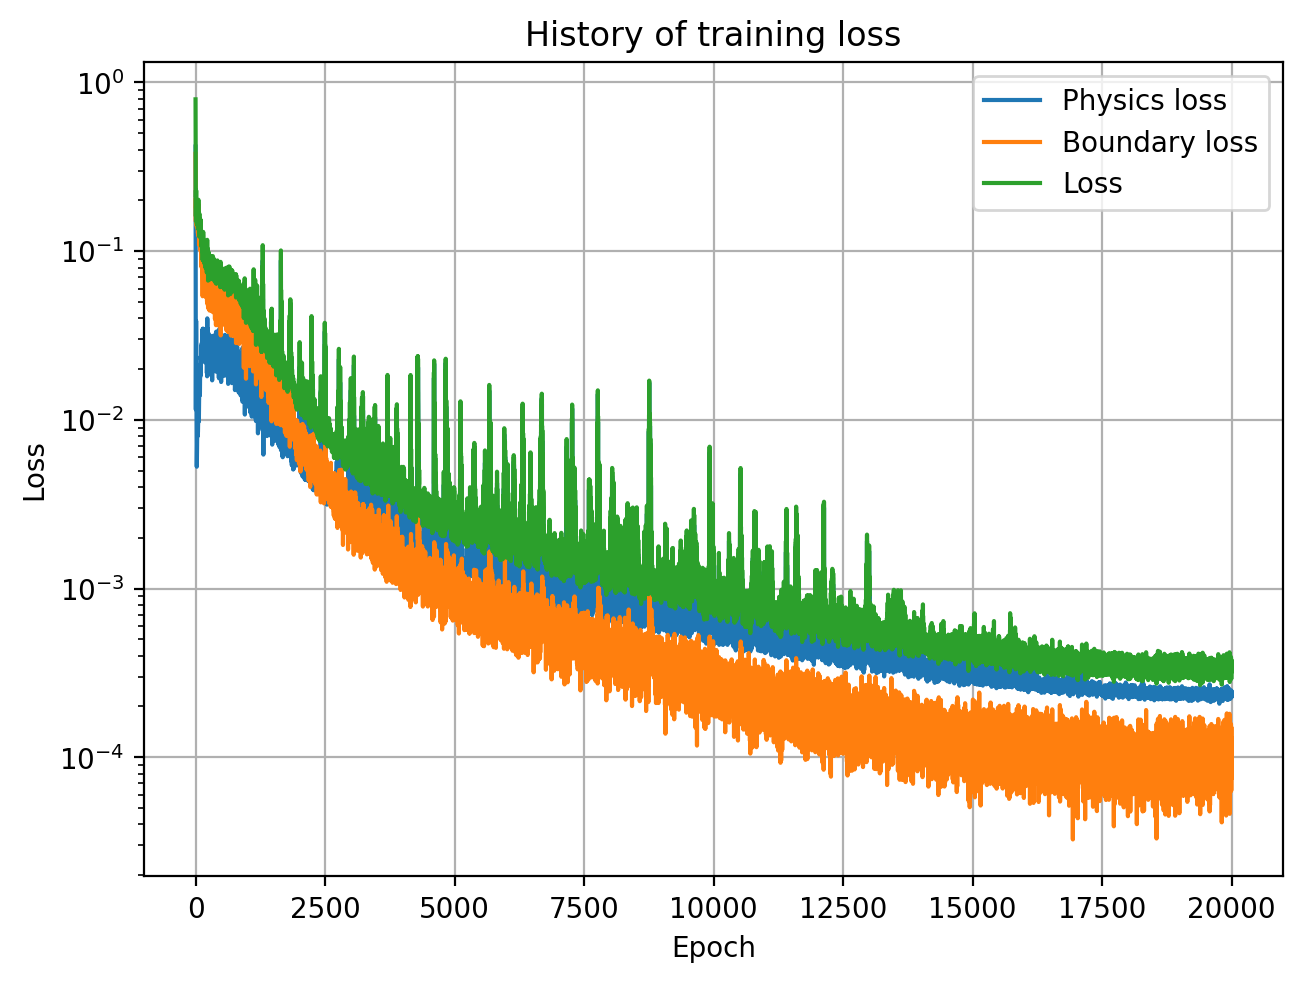

In [ ]:
fig, ax = plt.subplots()
ax.semilogy(physics_loss_history, label="Physics loss")
ax.semilogy(boundary_loss_history, label="Boundary loss")
ax.semilogy(loss_history, label="Loss")
ax.set(
    xlabel="Epoch",
    ylabel="Loss",
    title="History of training loss",
)
ax.legend()
ax.grid()
pass

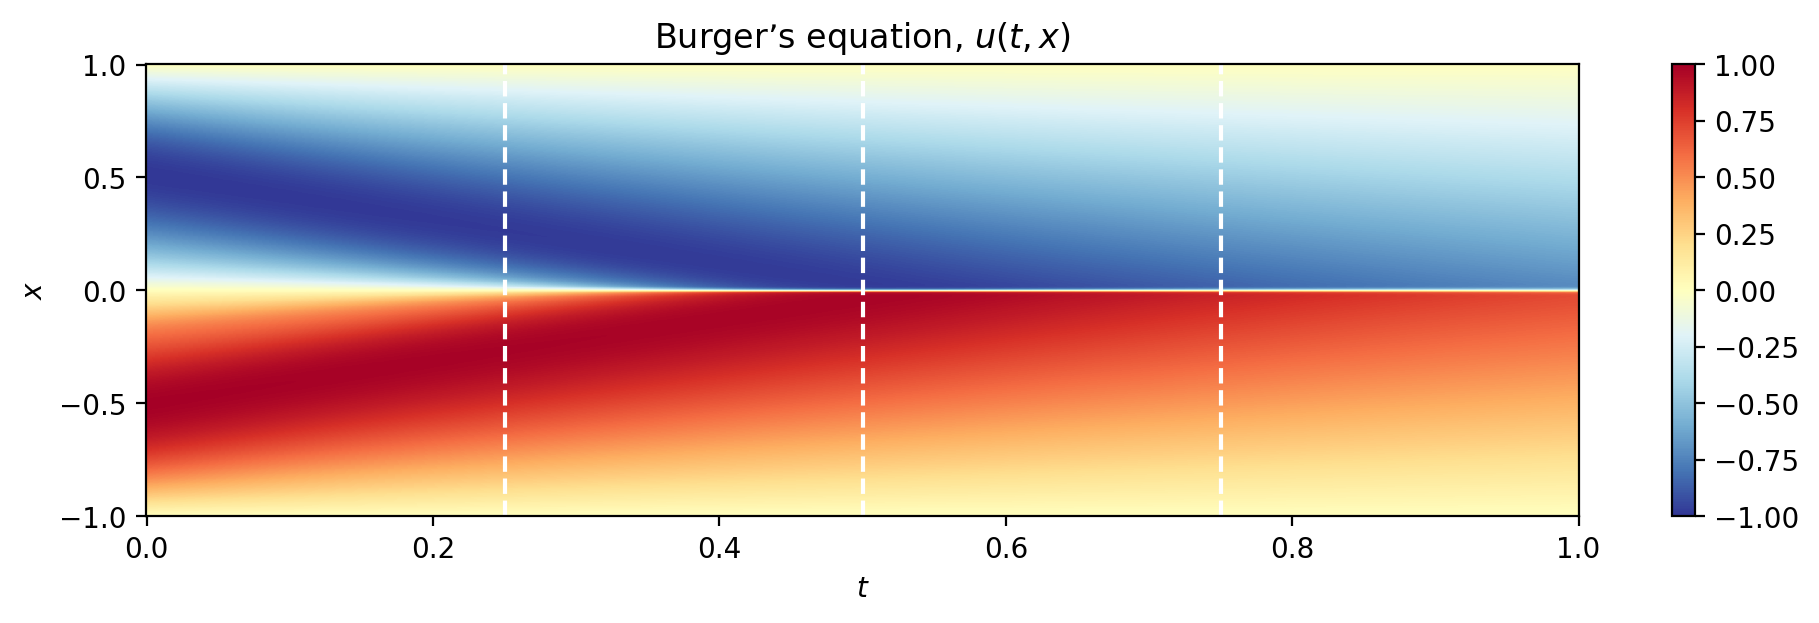

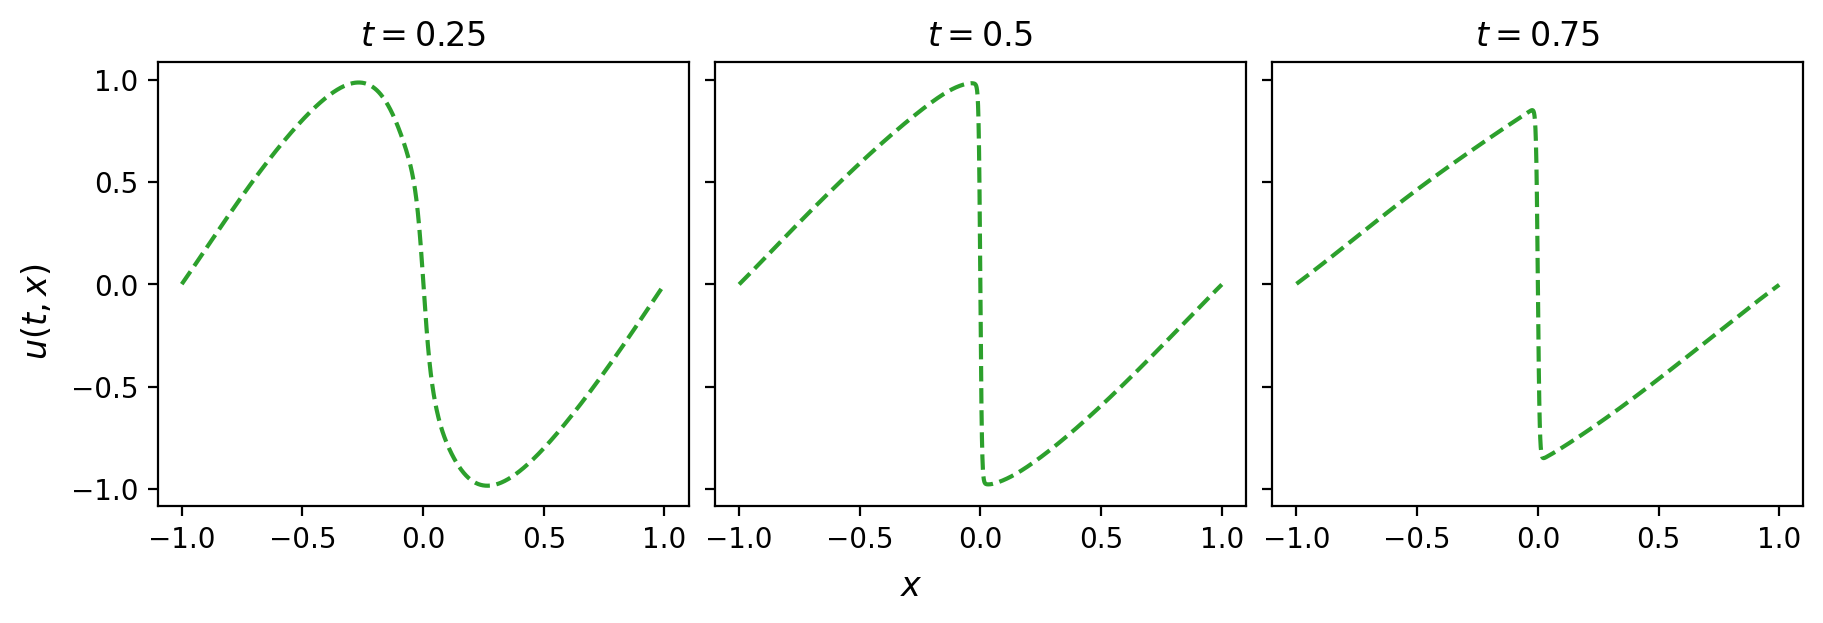

In [ ]:
t_slices = [0.25, 0.5, 0.75]

t = jnp.linspace(*domain_t, 1001)
x = jnp.linspace(*domain_x, 1001)

T, X = jnp.meshgrid(t, x)

u = batched_burger_u(params, T.ravel(), X.ravel()).reshape(T.shape)

fig, ax = plt.subplots(figsize=(9, 3))
pcolormesh = ax.pcolormesh(T, X, u, vmin=-1, vmax=1, cmap="RdYlBu_r")
fig.colorbar(pcolormesh, ax=ax)
ax.set(xlabel=R"$t$", ylabel=R"$x$", title=R"Burger’s equation, $u(t, x)$")
for t_slice in t_slices:
    ax.axvline(t_slice, c="w", ls="--")

fig, axes = plt.subplots(
    1, len(t_slices), figsize=(9, 3), sharex=True, sharey=True
)
for t_slice, ax in zip(t_slices, axes.flat):
    u = batched_burger_u(params, jnp.full_like(x, t_slice), x)
    ax.plot(x, u, c="C2", ls="--")
    ax.set_title(Rf"$t = {t_slice}$")
fig.supxlabel(R"$x$")
fig.supylabel(R"$u(t, x)$")
pass

## 2D Poisson’s equation: L-shaped domain

정의역: “L” shaped region

$$
\Omega = [-1, 1]^2 \setminus (0, 1]^2
$$

미분 방정식:

$$
-\Delta u = 1 \\
u(x, y) = 0 \quad \forall x, y \in \partial \Omega
$$

모델:

$$
u^\theta(x, y) = \operatorname{MLP}^\theta((x, y))
$$

손실 함수:

$$
L(\theta) = \frac{1}{N_\mathrm{phy}} \sum_{i = 1}^{N_\mathrm{phy}} (-\Delta u^\theta(x_i, y_i) - 1)^2
+ w \cdot \frac{1}{N_\mathrm{bdy}} \sum_{j = 1}^{N_\mathrm{bdy}} u^\theta(x_j, y_j)^2
$$


In [ ]:
# 문제와 모델 설정
# trianglated mesh에서보다 쉽게 다룰 수 있어요.
mlp = MLP((50, 50, 50, 50, 1))

# (), () -> ()
def poisson_u(params, x, y):
    return mlp.apply(params, jnp.array([x, y])).reshape()

# (N,), (N,) -> (N,)
batched_poisson_u = jax.vmap(poisson_u, in_axes=(None, 0, 0))

# (), () -> ()
# 위에서는 t랑 x를 분리해서 풀었어요. 2개짜리 벡터로 다루는게 더 쉬운데,
# x, y를 왜 따로 처리를 하냐면, 2번미분하는게 들어있기 때문에
# parameter가 많은데, 첫번째 줄만 계산해달라는게 Jax에는 없어요.
# 그래서 행렬을 계산하게 되면 Hessian을 구하게 되는데,
# 그렇게 되면 계산량이 많아져서요, x, y를 따로 풀어요.
def poisson_pde(params, x, y):
    u_xx = jax.jacfwd(jax.jacfwd(poisson_u, argnums=1), argnums=1)
    u_yy = jax.jacfwd(jax.jacfwd(poisson_u, argnums=2), argnums=2)
    # 두 번 미분하는 대신
    #     u_xx = jax.hessian(poisson_u, argnums=1)
    #     u_yy = jax.hessian(poisson_u, argnums=2)
    # 도 가능

    return -u_xx(params, x, y) - u_yy(params, x, y) - 1

# (N,), (N,) -> (N,)
batched_poisson_pde = jax.vmap(poisson_pde, in_axes=(None, 0, 0))

# (N_interior, 2), (N_boundary, 2) -> ()
def poisson_loss(params, xy_interior, xy_boundary, boundary_loss_weight):
    physics_loss = (
        batched_poisson_pde(params, xy_interior[:, 0], xy_interior[:, 1]) ** 2
    ).mean()
    boundary_loss = (
        batched_poisson_u(params, xy_boundary[:, 0], xy_boundary[:, 1]) ** 2
    ).mean()

    total_loss = physics_loss + boundary_loss_weight * boundary_loss

    return total_loss, (physics_loss, boundary_loss)

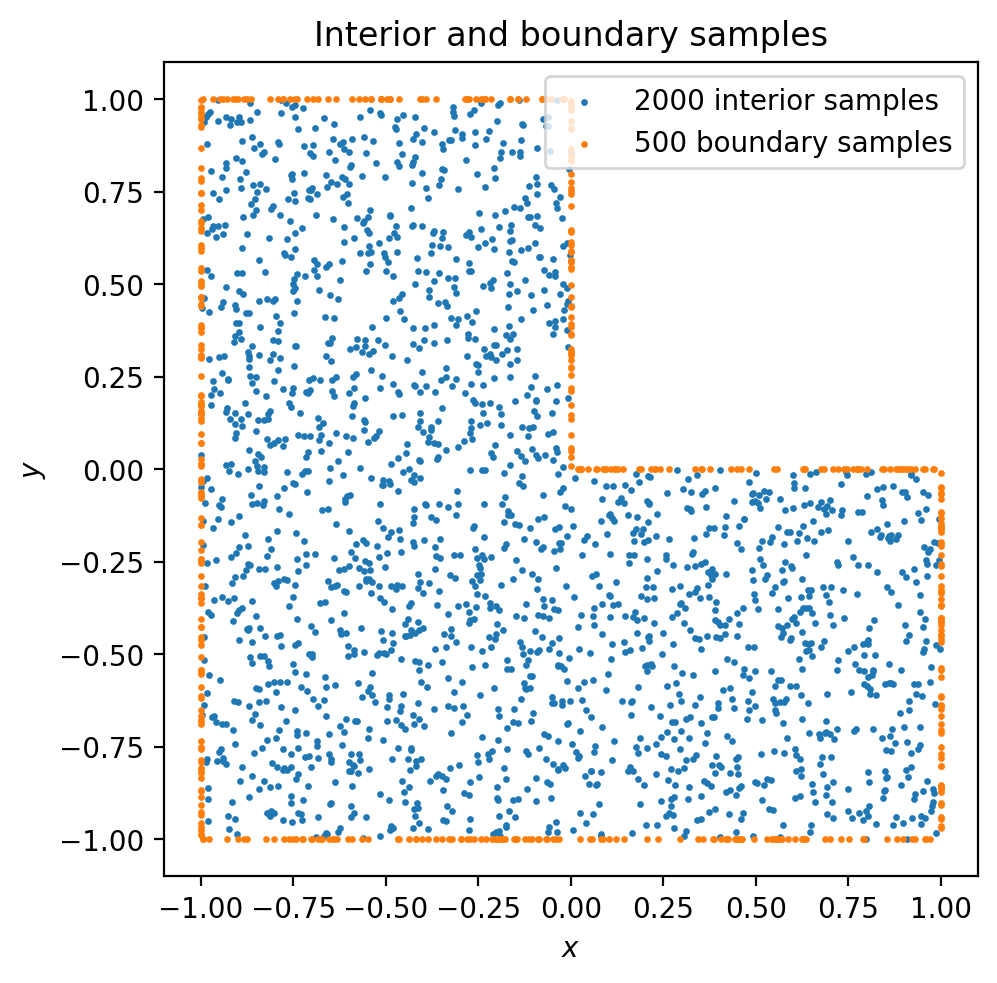

In [ ]:
# 샘플링
# uniform random 하게 샘플링했어요.
# quasi random 같은걸 쓰면 더 좋아질 수 있어요.
# sobol sequence같을걸 쓰면 좋아요.
@partial(jax.jit, static_argnums=(1,))
def sample_l_shaped_interior(key, n_samples):
    one_third_index = n_samples // 3
    two_thirds_index = 2 * (n_samples // 3)

    return (
        jax.random.uniform(key, shape=(n_samples, 2))
        .at[:one_third_index]
        .add(jnp.array([-1, 0]))  # 2사분면
        .at[one_third_index:two_thirds_index]
        .add(jnp.array([-1, -1]))  # 3사분면
        .at[two_thirds_index:]
        .add(jnp.array([0, -1]))  # 3사분면
    )

@partial(jax.jit, static_argnums=(1,))
def sample_l_shaped_boundary(key, n_samples):
    # FIXME: n_boundary_samples가 4의 배수가 아니면 샘플수가 달라짐
    top_x, bottom_x, left_y, right_y = jax.random.uniform(
        key, shape=(4, n_samples // 4), minval=-1, maxval=1
    )

    return jnp.concatenate([
        jnp.column_stack((top_x, jnp.where(top_x > 0, 0.0, 1.0))),
        jnp.column_stack((bottom_x, jnp.full_like(bottom_x, -1))),
        jnp.column_stack((jnp.full_like(left_y, -1), left_y)),
        jnp.column_stack((jnp.where(right_y > 0, 0.0, 1.0), right_y)),
    ])


interior_key, boundary_key = jax.random.split(jax.random.key(78))
xy_interior = sample_l_shaped_interior(interior_key, n_samples=2000)
xy_boundary = sample_l_shaped_boundary(interior_key, n_samples=500)

fig, ax = plt.subplots()
ax.scatter(
    xy_interior[:, 0],
    xy_interior[:, 1],
    s=2,
    label=f"{xy_interior.shape[0]} interior samples",
)
ax.scatter(
    xy_boundary[:, 0],
    xy_boundary[:, 1],
    s=2,
    label=f"{xy_boundary.shape[0]} boundary samples",
)
ax.legend()
ax.axis("square")
ax.set(xlabel=R"$x$", ylabel=R"$y$", title="Interior and boundary samples")
pass

In [ ]:
# 훈련 설정
model_key, data_key = jax.random.split(jax.random.key(78))
n_epochs = 20_000
learning_rate = optax.cosine_decay_schedule(1e-3, decay_steps=n_epochs)
n_interior_samples = 2000
n_boundary_samples = 500
boundary_loss_weight = 100
optimizer = optax.adam(learning_rate)

params = mlp.init(model_key, jnp.zeros((2,)))
optimizer_state = optimizer.init(params)

@jax.jit
def step(
    params, optimizer_state, xy_interior, xy_boundary, boundary_loss_weight
):
    loss, grads = jax.value_and_grad(poisson_loss, has_aux=True)(
        params, xy_interior, xy_boundary, boundary_loss_weight
    )
    updates, optimizer_state = optimizer.update(grads, optimizer_state)
    params = optax.apply_updates(params, updates)
    return params, optimizer_state, loss

In [ ]:
loss_history = []
physics_loss_history = []
boundary_loss_history = []

for i in tqdm(range(1, n_epochs + 1)):
    # 매번 새로운 무작위 점을 샘플링함
    data_key, interior_key, boundary_key = jax.random.split(data_key, 3)
    xy_interior = sample_l_shaped_interior(interior_key, n_interior_samples)
    xy_boundary = sample_l_shaped_boundary(boundary_key, n_boundary_samples)

    params, optimizer_state, (loss_value, (physics_loss, boundary_loss)) = (
        step(
            params,
            optimizer_state,
            xy_interior,
            xy_boundary,
            boundary_loss_weight,
        )
    )
    loss_history.append(loss_value.item())
    physics_loss_history.append(physics_loss.item())
    boundary_loss_history.append(boundary_loss.item())
    if i % (n_epochs // 20) == 0:
        tqdm.write(f"Epoch {i}: {loss_value = :g}")

  0%|          | 0/20000 [00:00<?, ?it/s]

Epoch 1000: loss_value = 0.0341865
Epoch 2000: loss_value = 0.0167454
Epoch 3000: loss_value = 0.0155744
Epoch 4000: loss_value = 0.00911103
Epoch 5000: loss_value = 0.00747599
Epoch 6000: loss_value = 0.00496405
Epoch 7000: loss_value = 0.00581562
Epoch 8000: loss_value = 0.00437273
Epoch 9000: loss_value = 0.00372093
Epoch 10000: loss_value = 0.00291332
Epoch 11000: loss_value = 0.00333737
Epoch 12000: loss_value = 0.00298942
Epoch 13000: loss_value = 0.00243883
Epoch 14000: loss_value = 0.0023244
Epoch 15000: loss_value = 0.00170458
Epoch 16000: loss_value = 0.00160649
Epoch 17000: loss_value = 0.00111424
Epoch 18000: loss_value = 0.00126102
Epoch 19000: loss_value = 0.00166158
Epoch 20000: loss_value = 0.00123109


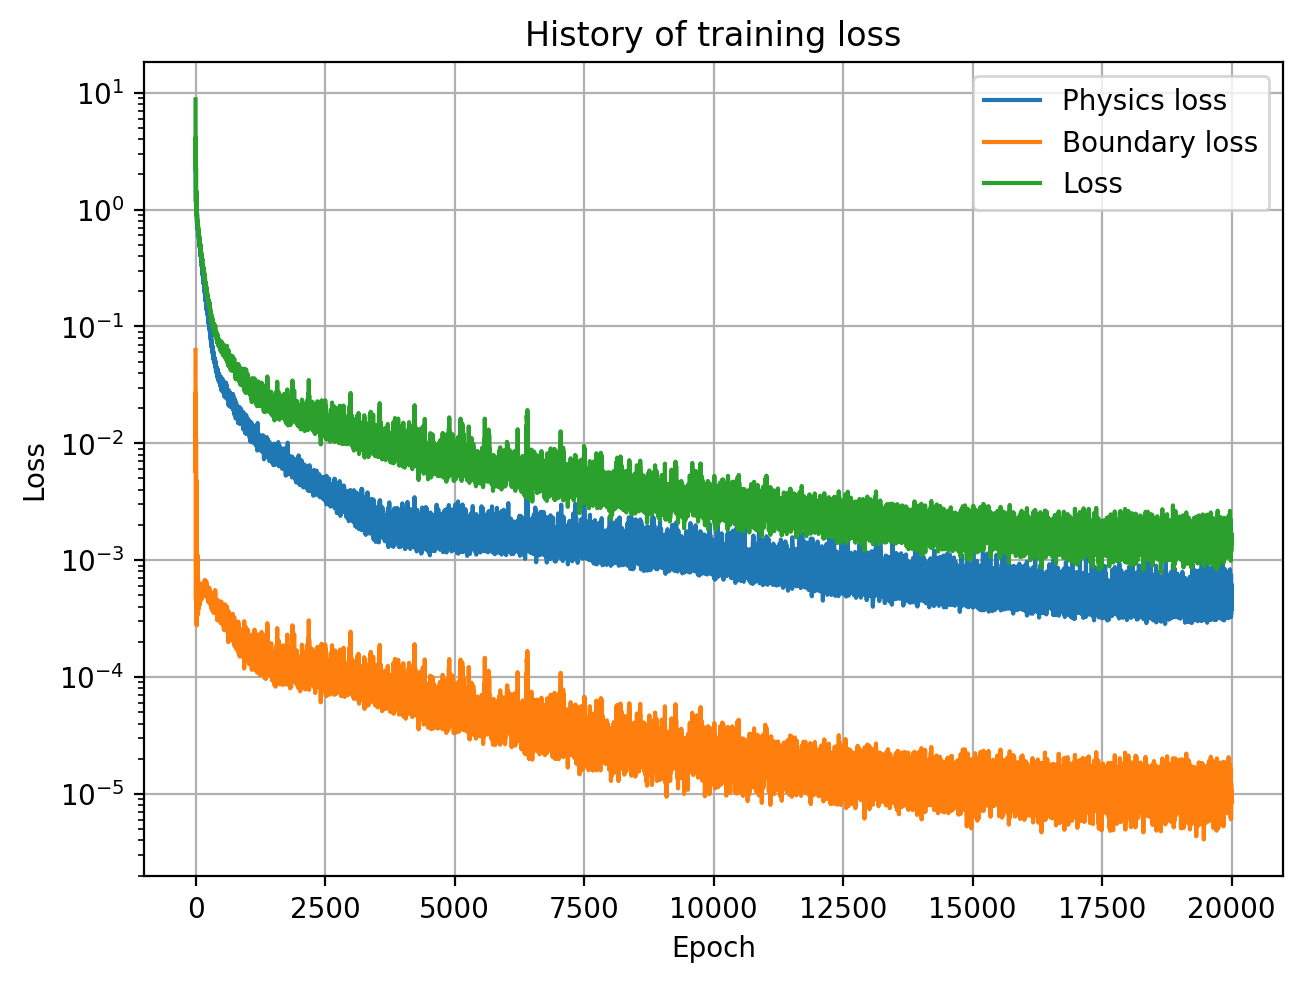

In [ ]:
fig, ax = plt.subplots()
ax.semilogy(physics_loss_history, label="Physics loss")
ax.semilogy(boundary_loss_history, label="Boundary loss")
ax.semilogy(loss_history, label="Loss")
ax.set(
    xlabel="Epoch",
    ylabel="Loss",
    title="History of training loss",
)
ax.legend()
ax.grid()
pass

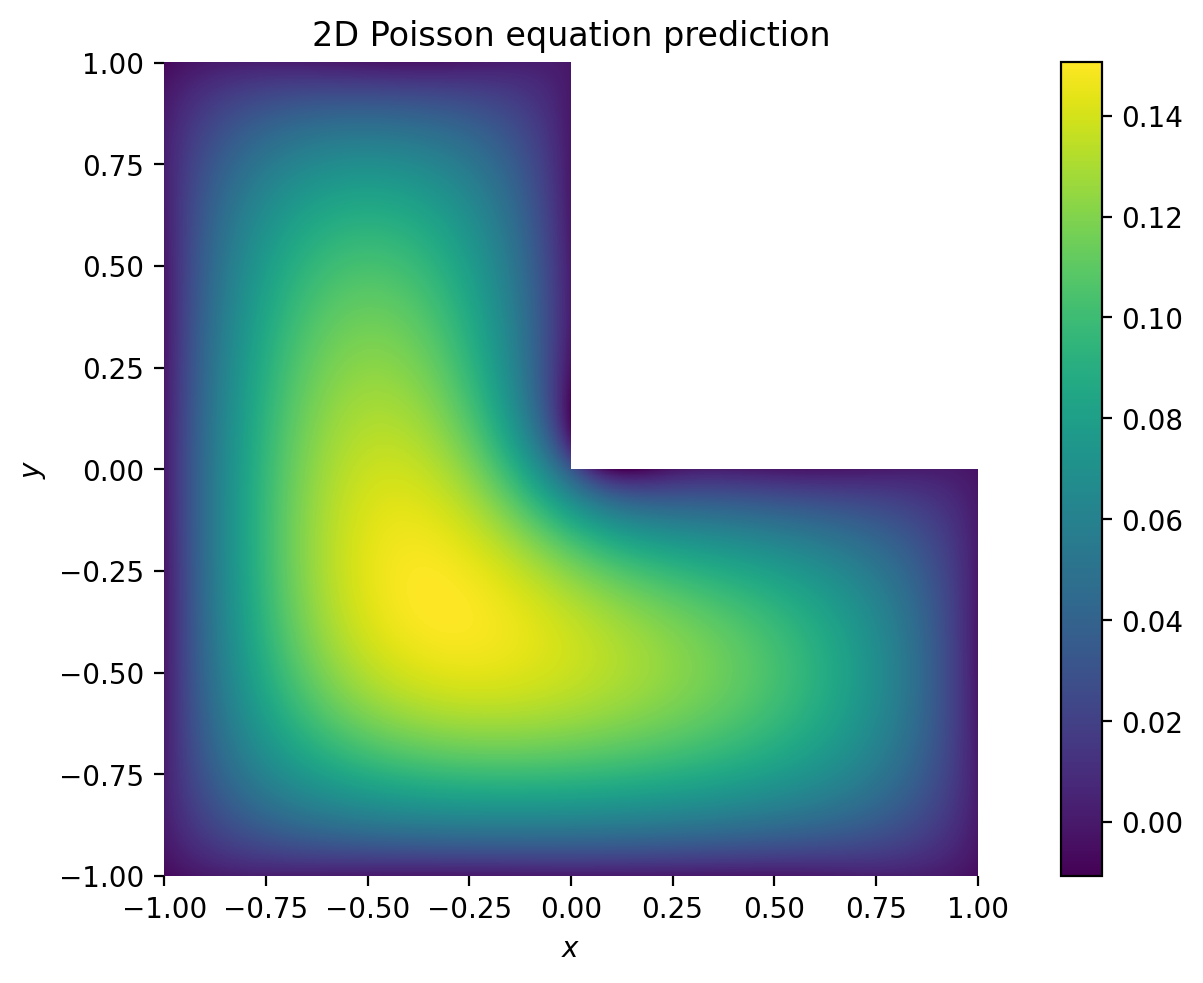

In [ ]:
# 트레이닝할때는 grid가 정해져있는게 아니고 랜덤하게 샘플링해서 학습했어요.
# 그릴 때는 grid를 정해놓고 그려요.
x = jnp.linspace(-1, 1, 1001)
y = jnp.linspace(-1, 1, 1001)

X, Y = jnp.meshgrid(x, y)

u = batched_poisson_u(params, X.ravel(), Y.ravel()).reshape(X.shape)
index = (X > 0) & (Y > 0)
u = u.at[index].set(np.nan)

fig, ax = plt.subplots()
pcolormesh = ax.pcolormesh(X, Y, u)  # contourf도 사용 가능
ax.spines[:].set_visible(False)
ax.axis("square")
fig.colorbar(pcolormesh, ax=ax)
ax.set(xlabel=R"$x$", ylabel=R"$y$", title="2D Poisson equation prediction")
pass

## 저항이 있는 포물선 운동: PINN + 데이터, 역문제(inverse problem)

상수 $\mu$를 알 수 없는 정체 미상의 물체가 언제 어디선가 던져졌고, (노이즈가 포함된) 일부 관측 데이터 $(t_j, \mathbf{s}_j)$를 얻은 상황을 가정합니다.
이 관측 데이터와 함께 물체가 다음 모델을 따르는 포물선 운동을 한다고 가정하고, 원래의 정보를 찾으려고 합니다.
(모델 구조상 관측 데이터를 일종의 경계(?) 조건으로 볼 수도 있습니다.)

미분 방정식:

2차원 공간에서 공의 현재 위치 $\mathbf{s} = (x, y)$, 속도 $\mathbf{v} = \mathbf{s}'$, 가속도 $\mathbf{a} = \mathbf{v}'$, 중력가속도 $\mathbf{g} = (0, -g) = (0, -9.8)$라 하면, 중력의 영향을 받고, 속도가 높아질수록 (공기 등의) 저항을 많이 받는 다음의 모델을 생각할 수 있습니다.

$$
\mathbf{a} = -\mu \lVert \mathbf{v} \rVert \mathbf{v} + \mathbf{g}
$$

모델:

$$
\mathbf{s}^\theta(t) = \operatorname{MLP}^\theta(t)
$$

(참고: $\mathbf{s}^\theta : \mathbb{R}^1 \to \mathbb{R}^2$)

손실 함수:

$$
L(\theta, \mu) = \frac{1}{N_\mathrm{phy}} \sum_{i = 1}^{N_\mathrm{phy}} \frac12 \Bigl\lVert \mathbf{s}_{tt}^\theta(t_i) + \mu \lVert \mathbf{s}_t^\theta(t_i) \rVert \mathbf{s}_t^\theta(t_i) - \mathbf{g} \Bigr\lVert^2
+ w \cdot \frac{1}{N_\mathrm{data}} \sum_{j = 1}^{N_\mathrm{data}} \frac12 \lVert \mathbf{s}_j - \mathbf{s}^\theta (t_j) \rVert^2
$$

<details><summary>참고: 수치해</summary>

$$
\frac{d}{dt} \begin{pmatrix} x \\ y \\ v_x \\ v_y \end{pmatrix}
= \begin{pmatrix}
    v_x \\
    v_y \\
    -\mu \sqrt{v_x^2 + v_y^2} \ v_x \\
    -\mu \sqrt{v_x^2 + v_y^2} \ v_y - g
\end{pmatrix}
$$

</details>

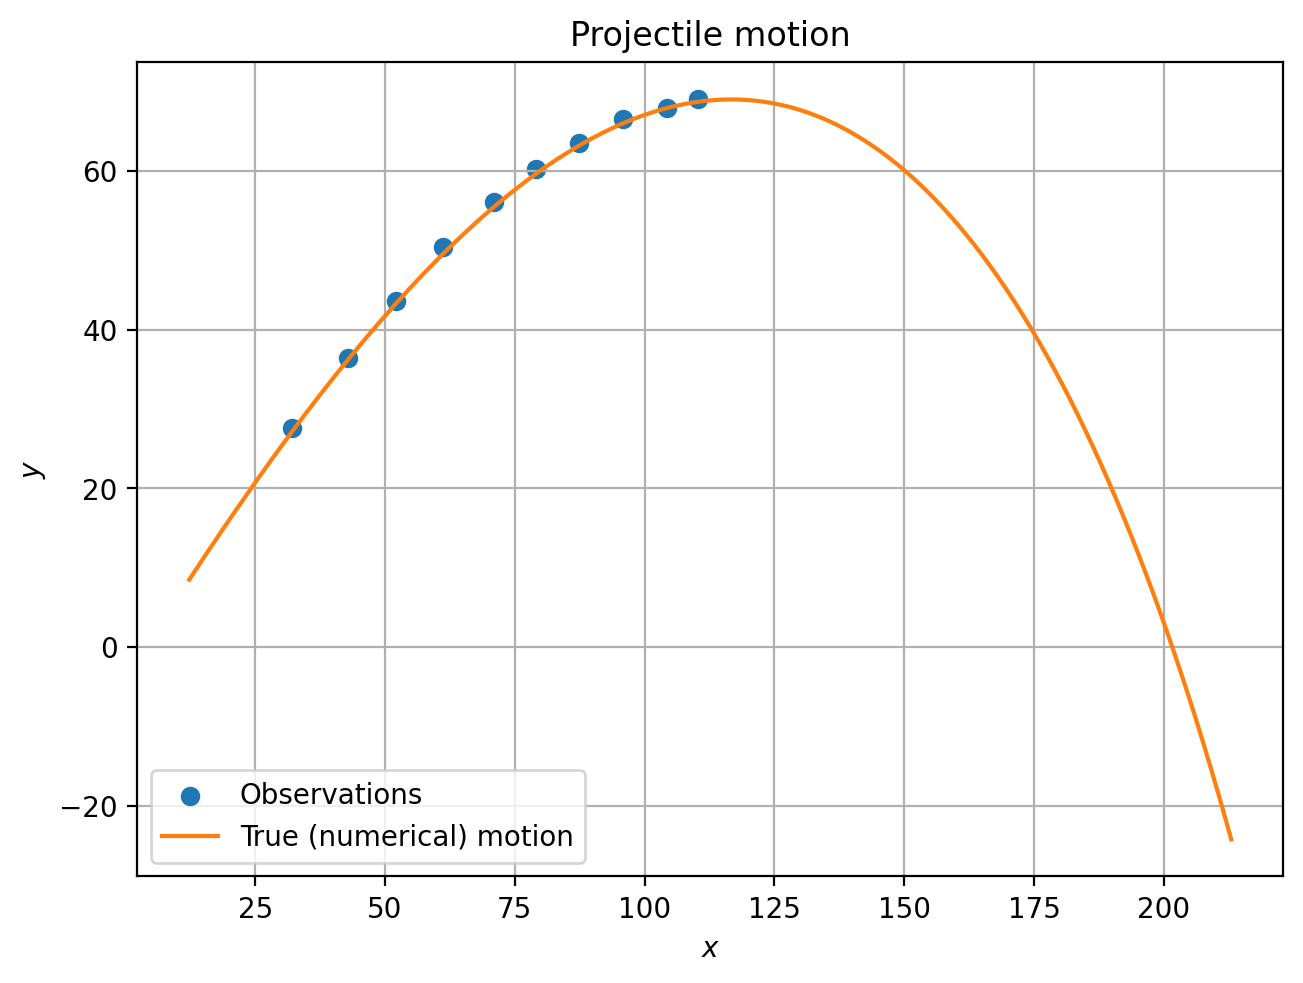

In [ ]:
# 데이터 생성
# 공을 던졌어요, 10번정도 센싱해가지고 찍었어요.
# 파란점(10번 센싱한거)이 날아온게 어디서 출발해서 어디로 날아가는지 알아가고 싶어요.
# (linear regression이든 뭐든 extrapolation에 취약해요.)
GRAVITY = 9.8

mu_true = 0.004
domain = (0.0, 8.0)
s0 = np.array([12.3, 8.5])  # 초기 위치
v0 = 60 * np.array([np.cos(np.pi / 4), np.sin(np.pi / 4)])  # 초기 속도

def projectile(t, sv):
    _, _, v_x, v_y = sv
    drag = mu_true * np.sqrt(v_x**2 + v_y**2)
    return np.array([v_x, v_y, -drag * v_x, -drag * v_y - GRAVITY])

sv0 = np.concatenate([s0, v0])
projectile_sol = sp.integrate.solve_ivp(
    projectile, domain, sv0, dense_output=True
)

# t = 0.5 ~ 3동안 10회의 오차를 포함한 관측 데이터가 있다고 가정
rng = np.random.default_rng(78)
t_observations_np = np.linspace(0.5, 3.0, 10)
s_observations_np = projectile_sol.sol(t_observations_np)[:2]
s_observations_np += rng.normal(scale=0.5, size=s_observations_np.shape)

t_dense = np.linspace(*domain, num=201)
s_numerical = projectile_sol.sol(t_dense)[:2]
observations_plot_options = {"c": "C0", "label": "Observations"}
true_plot_options = {"c": "C1", "label": "True (numerical) motion"}
prediction_plot_options = {"c": "C2", "ls": "--", "label": "Prediction"}
fig, ax = plt.subplots()
ax.scatter(
    s_observations_np[0], s_observations_np[1], **observations_plot_options
)
ax.plot(s_numerical[0], s_numerical[1], **true_plot_options)
ax.set(
    xlabel=R"$x$",
    ylabel=R"$y$",
    title="Projectile motion",
)
ax.grid()
ax.legend()
pass

In [ ]:
t_observations = jnp.array(t_observations_np, dtype=jnp.float32)
s_observations = jnp.array(s_observations_np.T, dtype=jnp.float32)

In [ ]:
# 문제와 모델 설정
# 공이 날아가는건 PDE로 풀고, 파란색 관찰 data로부터 mu를 찾는거에요.
mlp = MLP((64, 128, 2))

# () -> (2,)
def projectile_s(params, t):
    return mlp.apply(params, jnp.array([t]))

# (N,) -> (N, 2)
batched_projectile_s = jax.vmap(projectile_s, in_axes=(None, 0))

# () -> (2,)
def projectile_pde(params, t):
    v = jax.jacfwd(projectile_s, argnums=1)
    a = jax.jacfwd(v, argnums=1)

    v_value = v(params, t)
    a_value = a(params, t)
    mu = jnp.exp(params["pde_params"]["log_mu"])
    # log mu에 exp을 취하면 항상 양수가 나와요.
    return (
        a_value
        + mu * jnp.linalg.norm(v_value) * v_value
        - jnp.array([0.0, -GRAVITY])
    )

# (N,) -> (N, 2)
batched_projectile_pde = jax.vmap(projectile_pde, in_axes=(None, 0))

# (N_phy,), (N_data,), (N_data, 2) -> ()
def projectile_loss(
    params, t_samples, t_observations, s_observations, data_loss_weight
):
    physics_loss = (batched_projectile_pde(params, t_samples) ** 2).mean()
    data_loss = (
        (s_observations - batched_projectile_s(params, t_observations)) ** 2
    ).mean()

    total_loss = physics_loss + data_loss_weight * data_loss

    return total_loss, (physics_loss, data_loss)

In [ ]:
# 샘플링
@partial(jax.jit, static_argnums=(1,))
def sample_projectile(key, n_samples):
    return jax.random.uniform(
        sample_subkey,
        shape=(n_samples,),
        minval=domain[0],
        maxval=domain[1],
    )

In [ ]:
# 훈련 설정
model_key, sample_key = jax.random.split(jax.random.key(78))
n_epochs = 40_000
learning_rate = optax.cosine_decay_schedule(3e-3, decay_steps=n_epochs)
n_samples = 200
data_loss_weight = 0.1
optimizer = optax.adam(learning_rate)

params = (
    mlp.init(model_key, jnp.zeros((1,)))
    | {"pde_params": {"log_mu": jnp.array(0.0)}}
)
optimizer_state = optimizer.init(params)

@jax.jit
def step(params, optimizer_state, t_samples, t_observations, s_observations):
    loss, grads = jax.value_and_grad(projectile_loss, has_aux=True)(
        params, t_samples, t_observations, s_observations, data_loss_weight
    )
    updates, optimizer_state = optimizer.update(grads, optimizer_state)
    params = optax.apply_updates(params, updates)
    return params, optimizer_state, loss

In [ ]:
loss_history = []
physics_loss_history = []
data_loss_history = []

for i in tqdm(range(1, n_epochs + 1)):
    sample_key, sample_subkey = jax.random.split(sample_key)
    t_samples = sample_projectile(sample_subkey, n_samples)

    params, optimizer_state, (loss_value, (physics_loss, data_loss)) = step(
        params, optimizer_state, t_samples, t_observations, s_observations
    )
    loss_history.append(loss_value.item())
    physics_loss_history.append(physics_loss.item())
    data_loss_history.append(data_loss.item())
    if i % (n_epochs // 20) == 0:
        tqdm.write(
            f"Epoch {i}: {loss_value = :g}, mu = {jnp.exp(params['pde_params']['log_mu']):.6f}"
        )

  0%|          | 0/40000 [00:00<?, ?it/s]

Epoch 2000: loss_value = 41.6249, mu = 0.583534
Epoch 4000: loss_value = 37.3631, mu = 0.220695
Epoch 6000: loss_value = 22.1366, mu = 0.056302
Epoch 8000: loss_value = 3.67098, mu = 0.021186
Epoch 10000: loss_value = 0.874728, mu = 0.015551
Epoch 12000: loss_value = 0.700026, mu = 0.014245
Epoch 14000: loss_value = 0.385354, mu = 0.011594
Epoch 16000: loss_value = 0.128172, mu = 0.008255
Epoch 18000: loss_value = 0.0377558, mu = 0.006024
Epoch 20000: loss_value = 0.0168803, mu = 0.004834
Epoch 22000: loss_value = 0.0126876, mu = 0.004289
Epoch 24000: loss_value = 0.0192428, mu = 0.004107
Epoch 26000: loss_value = 0.0123301, mu = 0.004061
Epoch 28000: loss_value = 0.0122077, mu = 0.004050
Epoch 30000: loss_value = 0.012374, mu = 0.004046
Epoch 32000: loss_value = 0.0120021, mu = 0.004044
Epoch 34000: loss_value = 0.011999, mu = 0.004043
Epoch 36000: loss_value = 0.011993, mu = 0.004042
Epoch 38000: loss_value = 0.011991, mu = 0.004042
Epoch 40000: loss_value = 0.0119906, mu = 0.004042


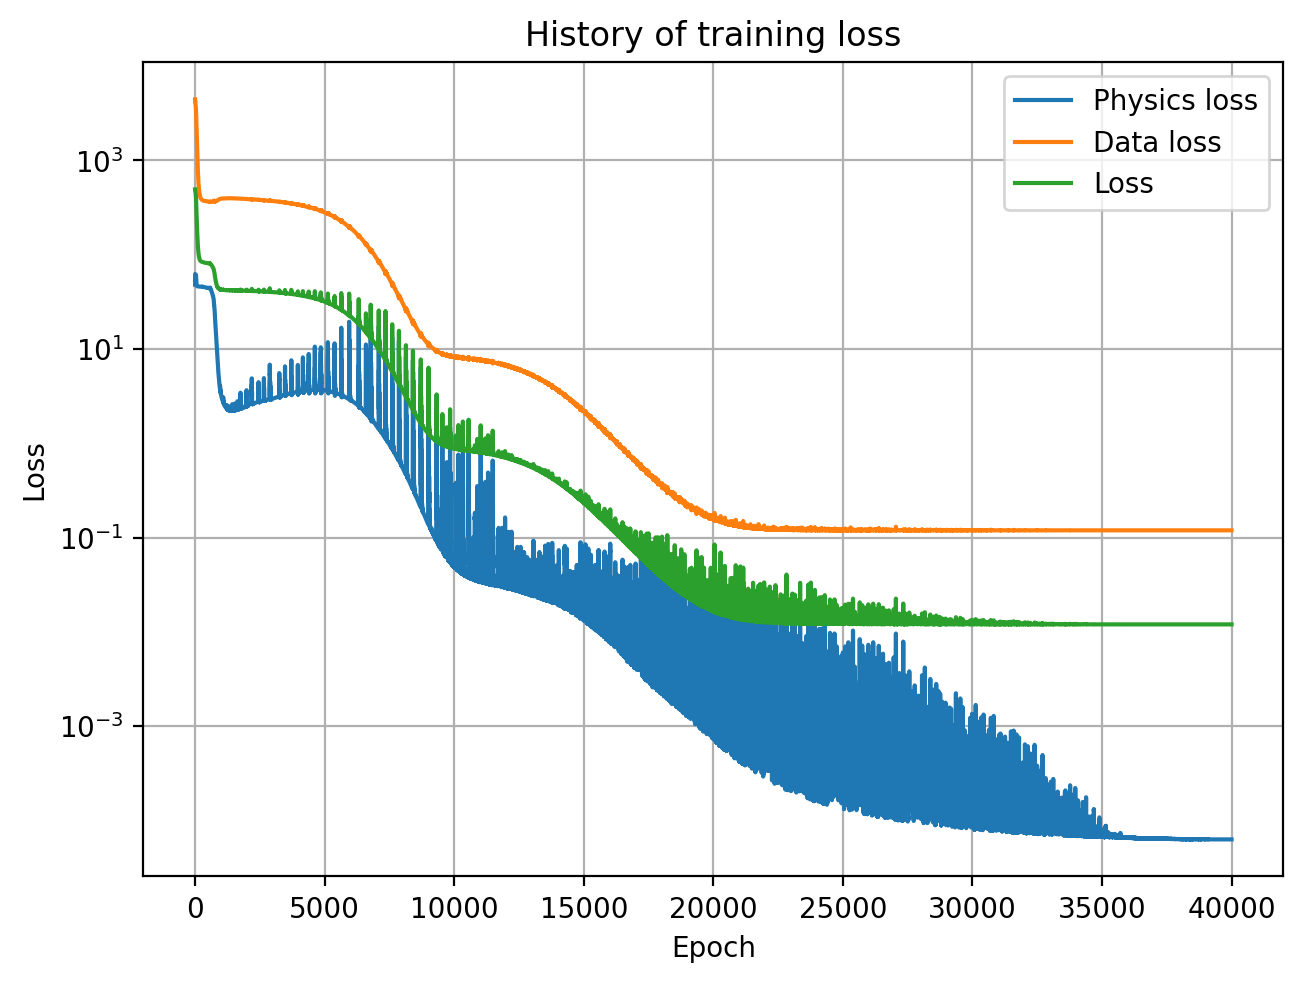

In [ ]:
fig, ax = plt.subplots()
ax.semilogy(physics_loss_history, label="Physics loss")
ax.semilogy(data_loss_history, label="Data loss")
ax.semilogy(loss_history, label="Loss")
ax.set(
    xlabel="Epoch",
    ylabel="Loss",
    title="History of training loss",
)
ax.legend()
ax.grid()
pass

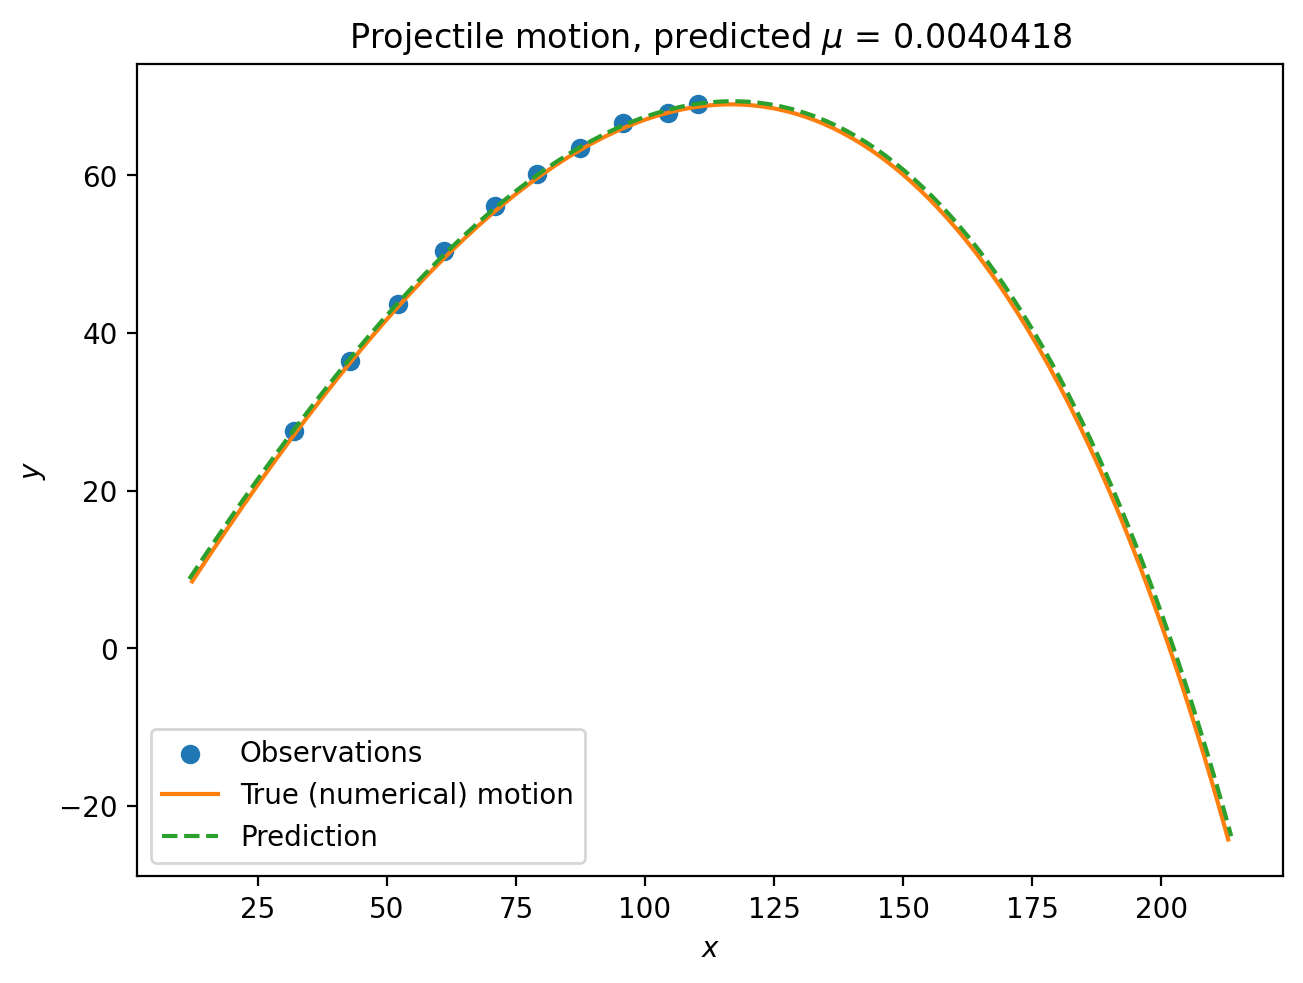

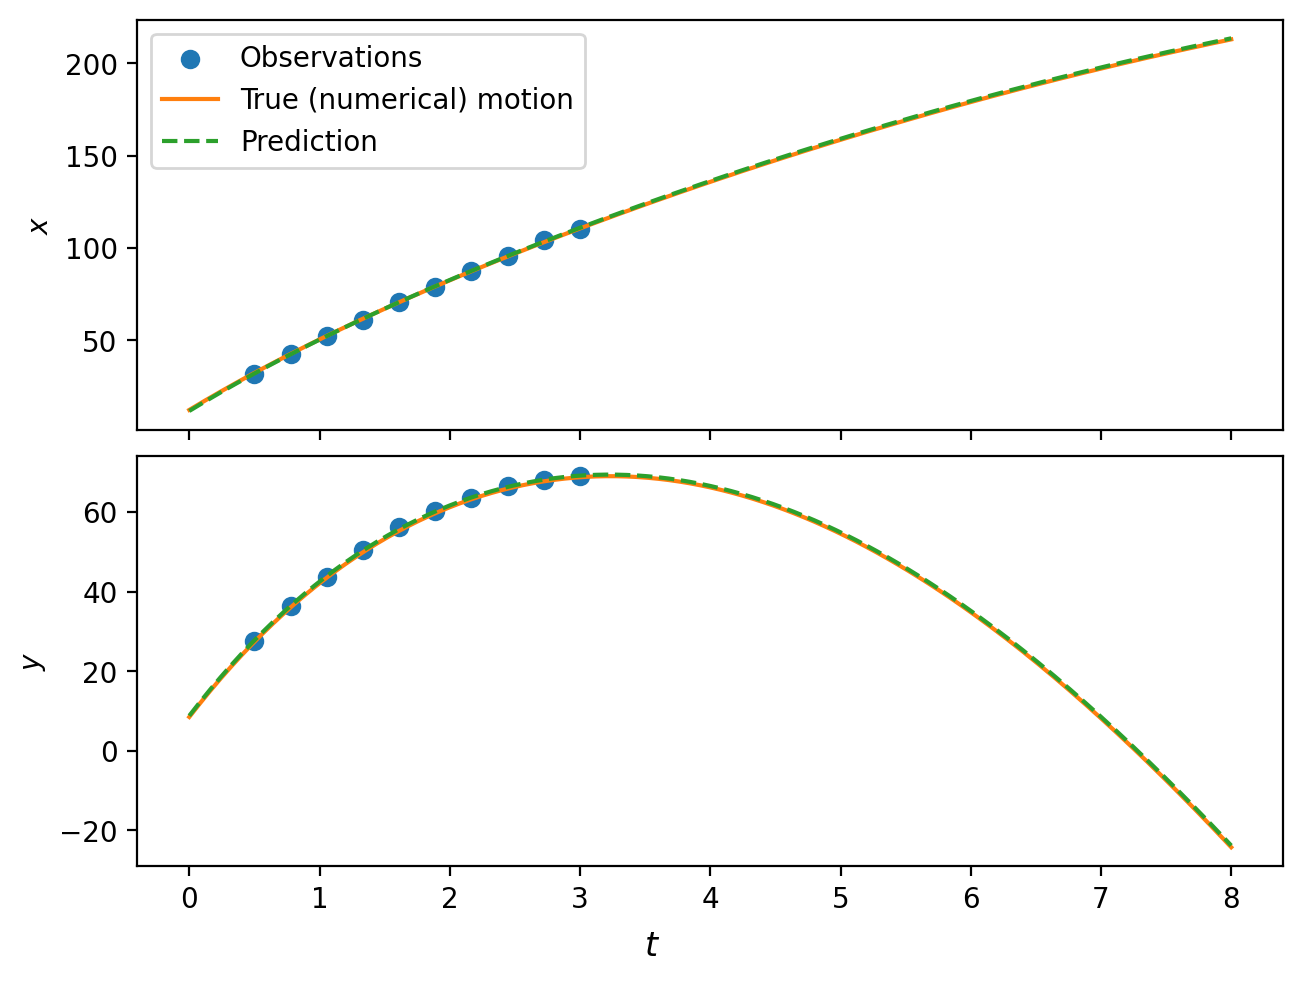

In [ ]:
s = batched_projectile_s(params, t_dense)

fig, ax = plt.subplots()
ax.scatter(
    s_observations_np[0],
    s_observations_np[1],
    **observations_plot_options,
)
ax.plot(s_numerical[0], s_numerical[1], **true_plot_options)
ax.plot(s[:, 0], s[:, 1], **prediction_plot_options)
ax.set(
    xlabel=R"$x$",
    ylabel=R"$y$",
    title=Rf"Projectile motion, predicted $\mu$ = {jnp.exp(params['pde_params']['log_mu']).item():.7f}",
)
ax.legend()
# 이렇게 하면 inverse problem을 풀어서 mu를 찾을 수 있는데,
# data가 포함되어있고, 그럼 그 data가 mu에 대한 정보도 갖고 있으니까
# mu 값을 찾을 수 있다.
# Allen-Cahn이나 Cahn-Hilliard equations도 epsilon 찾을 수 있을듯.
fig, axes = plt.subplots(2, 1, sharex=True)
for i in range(2):
    axes[i].scatter(
        t_observations,
        s_observations[:, i],
        **observations_plot_options,
    )
    axes[i].plot(t_dense, s_numerical[i], **true_plot_options)
    axes[i].plot(t_dense, s[:, i], **prediction_plot_options)
axes[0].set_ylabel(R"$x$")
axes[0].legend()
axes[1].set_ylabel(R"$y$")
fig.supxlabel(R"$t$")
pass